# Clasificaci√≥n de g√©neros con CNN y GTZAN

Este proyecto tiene como objetivo clasificar g√©neros musicales utilizando redes neuronales convolucionales (CNN) a partir de representaciones ac√∫sticas del audio. Se utiliza el dataset GTZAN, que contiene 1000 archivos de 30 segundos distribuidos en 10 g√©neros musicales.


## Cargar librer√≠as necesarias

In [11]:
# Instalar librosa (para extracci√≥n de caracter√≠sticas de audio)
!pip install librosa soundfile --quiet


In [12]:
# Librer√≠as esenciales para manipulaci√≥n de archivos, arrays num√©ricos y visualizaci√≥n
import os
import numpy as np
import matplotlib.pyplot as plt

# Librer√≠as espec√≠ficas para audio
import librosa
import librosa.display

# Utilidades de machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Utilidades de redes neuronales
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, LeakyReLU, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar Google Drive (si est√°s en Google Colab)

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definir ruta del dataset y explorar g√©neros en el dataset

In [14]:
DATASET_PATH = '/content/drive/MyDrive/Proyecto_Final_Mineria/Data/genres_original'  # Modific√° esta ruta si tu carpeta es distinta
GENRES = sorted(os.listdir(DATASET_PATH))
print("G√©neros encontrados:", GENRES)


G√©neros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Funci√≥n para convertir audio a espectrograma Mel

¬øPor qu√© usar melspectrogramas?
Los melspectrogramas son una representaci√≥n visual del audio que muestra c√≥mo la energ√≠a de diferentes frecuencias var√≠a a lo largo del tiempo, utilizando una escala mel que simula la percepci√≥n auditiva humana. Esta representaci√≥n convierte la se√±al de audio en una imagen, lo que permite que las redes neuronales convolucionales (CNN) puedan analizar patrones temporales y frecuenciales, facilitando la identificaci√≥n de caracter√≠sticas propias de cada g√©nero musical.

Gracias a esta transformaci√≥n, el modelo puede aprender mejor las texturas y ritmos propios de cada g√©nero, mejorando la precisi√≥n de la clasificaci√≥n.



In [15]:
def audio_a_melspectrogram(path, max_pad_len=660):
    """
    Convierte un archivo de audio .wav a un espectrograma Mel,
    que es una representaci√≥n visual de la energ√≠a en diferentes frecuencias a lo largo del tiempo.

    El resultado es una matriz 2D (como una imagen), que luego se expande con una dimensi√≥n de canal para usar en la red neuronal.
    """

    if not os.path.exists(path):
        print(f"Advertencia: Archivo no encontrado en {path}")
        return None

    try:
        # Cargar audio con duraci√≥n fija de 30 segundos
        y, sr = librosa.load(path, duration=30)

        # Si el audio dura menos, se rellena con ceros
        if len(y) < sr * 30:
            y = np.pad(y, (0, sr * 30 - len(y)), 'constant')

        # Generar espectrograma Mel (128 bandas de frecuencia)
        melspectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)

        # Convertir a escala logar√≠tmica (decibeles)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)

        # Recortar o rellenar para que todas las matrices tengan la misma longitud horizontal
        if melspectrogram_db.shape[1] < max_pad_len:
            pad_width = max_pad_len - melspectrogram_db.shape[1]
            melspectrogram_db = np.pad(melspectrogram_db, ((0, 0), (0, pad_width)))
        else:
            melspectrogram_db = melspectrogram_db[:, :max_pad_len]

        # Expandir la dimensi√≥n para que tenga forma (128, 660, 1) como una imagen con un solo canal
        return np.expand_dims(melspectrogram_db, axis=-1)

    except Exception as e:
        print(f"Error al procesar {os.path.basename(path)}: {e}")
        return None


## Cargar y procesar todos los archivos de audio

In [22]:
X, y = [], []  # X guardar√° los espectrogramas, y las etiquetas (g√©neros)

for genre in GENRES:
    genre_dir = os.path.join(DATASET_PATH, genre)

    # Verificamos que la carpeta del g√©nero exista
    if not os.path.isdir(genre_dir):
        continue

    for file in os.listdir(genre_dir):
        if file.endswith(".wav"):  # Solo procesamos archivos .wav
            path = os.path.join(genre_dir, file)

            # Convertimos a espectrograma Mel
            spec = audio_a_melspectrogram(path)

            # Si la conversi√≥n fue exitosa, lo agregamos al dataset
            if spec is not None:
                X.append(spec)
                y.append(genre)

Este bucle recorre todas las carpetas (una por g√©nero) y convierte cada audio a su correspondiente imagen espectral. Tambi√©n filtra archivos que no sean .wav.


# Limpiar posibles entradas inv√°lidas

In [24]:
X_clean = []
y_clean = []

for xi, yi in zip(X, y):
    if xi is not None:
        X_clean.append(xi)
        y_clean.append(yi)

# Convertimos listas a arrays NumPy para entrenamiento
X = np.array(X_clean)
y = np.array(y_clean)

print("Forma final de X:", X.shape)
print("Clases √∫nicas:", np.unique(y))

Forma final de X: (999, 128, 660, 1)
Clases √∫nicas: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## Visualizar un espectrograma Mel

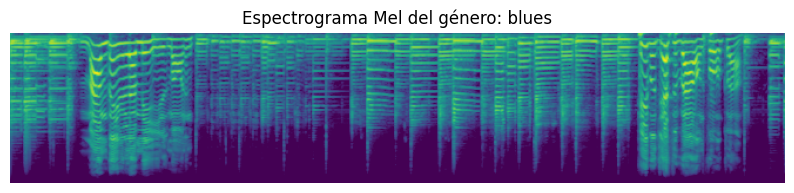

In [25]:
# Mostramos el primer espectrograma del dataset
plt.figure(figsize=(10, 2))
plt.imshow(X[0])
plt.title(f"Espectrograma Mel del g√©nero: {y[0]}")
plt.axis('off')
plt.show()

Este gr√°fico muestra la energ√≠a de diferentes frecuencias (en el eje vertical) a lo largo del tiempo (horizontal). Las zonas m√°s claras indican m√°s energ√≠a.
Esta t√©cnica transforma la se√±al de audio en una matriz 2D que representa la energ√≠a en diferentes bandas de frecuencia mel a lo largo del tiempo. La escala mel simula c√≥mo el o√≠do humano percibe el sonido. Los valores se convirtieron a decibeles (escala logar√≠tmica) y se ajustaron a una forma fija (128√ó660) para ser usados como im√°genes monocanal en una red neuronal convolucional.

## Promedio de espectrogramas por g√©nero

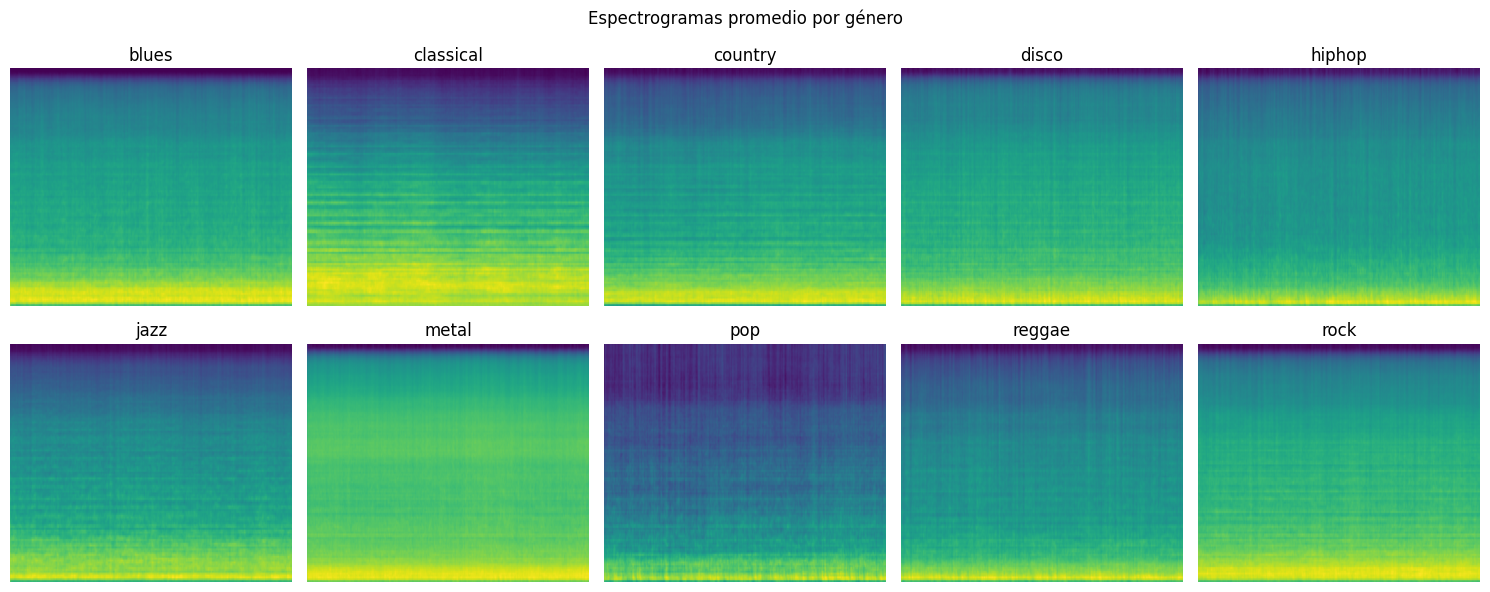

In [26]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx, genre in enumerate(np.unique(y)):
    idxs = [i for i, g in enumerate(y) if g == genre]
    mean_spec = np.mean(X[idxs], axis=0).squeeze()
    ax = axs[idx // 5, idx % 5]
    ax.imshow(mean_spec, aspect='auto', origin='lower')
    ax.set_title(genre)
    ax.axis('off')
plt.suptitle("Espectrogramas promedio por g√©nero")
plt.tight_layout()
plt.show()

## Distribuci√≥n de ejemplos por clase


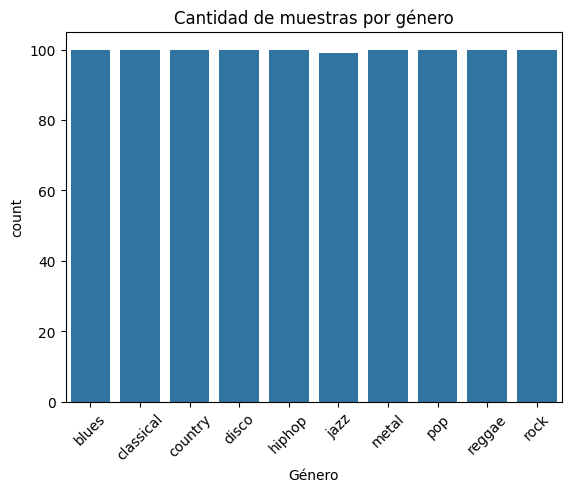

In [27]:
import seaborn as sns
import pandas as pd

sns.countplot(data=pd.DataFrame(y, columns=["G√©nero"]), x="G√©nero")
plt.title("Cantidad de muestras por g√©nero")
plt.xticks(rotation=45)
plt.show()


Todos los g√©neros del dataset contienen 100 archivos de audio, excepto el g√©nero jazz, para el cual se elimin√≥ manualmente un archivo corrupto. Esta limpieza podr√≠a automatizarse mediante c√≥digo, pero en este caso se realiz√≥ directamente desde Google Drive.

## Reducci√≥n de dimensionalidad con PCA para visualizaci√≥n

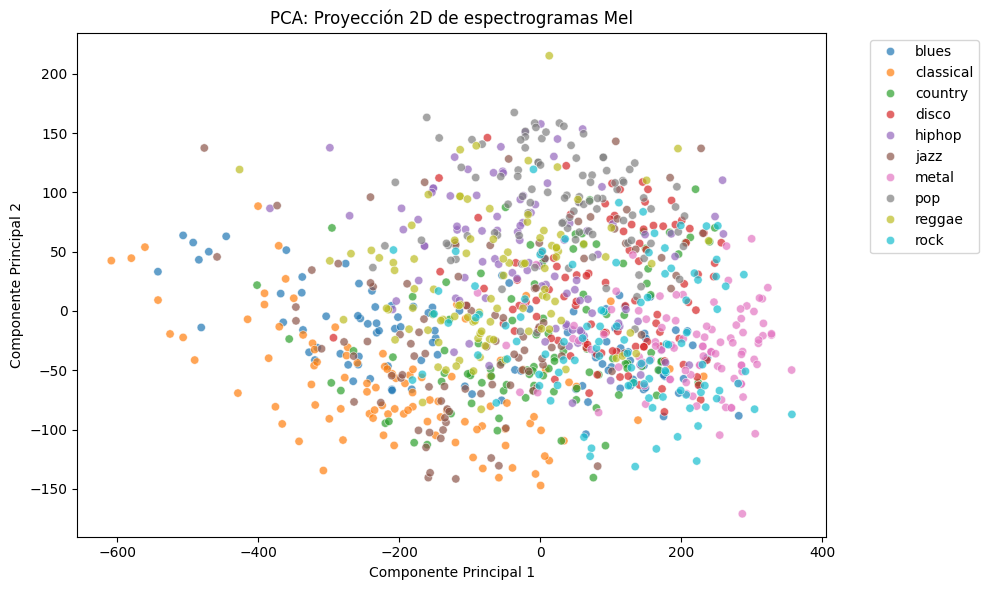

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

# Aplanamos los espectrogramas para que cada uno sea un vector 1D
X_flat = X.reshape(X.shape[0], -1)

# Estandarizamos los datos (PCA es sensible a la escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Aplicamos PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convertimos a DataFrame para graficar
df_pca = pd.DataFrame()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]
df_pca['G√©nero'] = y

# Graficamos los g√©neros en el nuevo espacio 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='G√©nero', palette='tab10', alpha=0.7)
plt.title("PCA: Proyecci√≥n 2D de espectrogramas Mel")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### An√°lisis con PCA para visualizaci√≥n de g√©neros musicales

Aplicamos PCA (An√°lisis de Componentes Principales) para reducir la dimensionalidad de los espectrogramas (originalmente matrices grandes) a dos dimensiones, facilitando su visualizaci√≥n.

Esta t√©cnica nos permite observar si los datos presentan agrupaciones o separaciones claras entre los diferentes g√©neros musicales. En el gr√°fico, cada punto representa un espectrograma proyectado en 2D, coloreado seg√∫n su g√©nero.

La presencia de cl√∫steres definidos indica que los g√©neros tienen patrones diferenciables, lo cual es un buen indicio para la clasificaci√≥n autom√°tica. Sin embargo, algunos g√©neros pueden solaparse parcialmente, lo que sugiere posibles confusiones en el modelo.

En resumen, PCA nos ofrece una validaci√≥n visual y exploratoria √∫til para entender la estructura y la separabilidad de los datos antes de entrenar modelos de clasificaci√≥n.


## Codificar etiquetas (Label Encoding + One-Hot)



In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Transformamos etiquetas de texto (e.g. 'rock') a n√∫meros (e.g. 7)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Convertimos a codificaci√≥n one-hot para la red (una columna por g√©nero)
y_onehot = to_categorical(y_encoded)


 Las redes neuronales no entienden texto. As√≠ que convertimos cada g√©nero musical en un n√∫mero y luego en un vector binario donde solo una posici√≥n est√° encendida. Por ejemplo: [0 0 1 0 0 0 0 0 0 0] podr√≠a ser 'jazz'.


## Divisi√≥n entre entrenamiento y prueba

In [30]:
from sklearn.model_selection import train_test_split

# Dividimos en un 80% para entrenamiento y 20% para validaci√≥n
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42)

## Definir modelo CNN para clasificaci√≥n de g√©nero

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dropout, Dense)

model = Sequential([

    # üß± Bloque 1: Primeras caracter√≠sticas b√°sicas
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(X.shape[1], X.shape[2], X.shape[3])),  # Extrae 32 mapas de caracter√≠sticas con filtros 3x3
    MaxPooling2D((2, 2)),        # Reduce resoluci√≥n para conservar solo lo importante
    BatchNormalization(),        # Normaliza activaciones para acelerar entrenamiento

    # üß± Bloque 2: Caracter√≠sticas m√°s complejas
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Ahora 64 filtros extraen informaci√≥n m√°s detallada
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # üß± Bloque 3: A√∫n m√°s profundidad
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # üß± Bloque 4: Aprendizaje profundo de patrones
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Extrae patrones a√∫n m√°s abstractos
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # üß± Bloque 5: Representaciones de alto nivel
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Mucha capacidad de aprendizaje
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # üîö Clasificaci√≥n final
    GlobalAveragePooling2D(),  # Reduce cada mapa de activaci√≥n a un n√∫mero promedio (menos par√°metros)
    Dropout(0.6),              # Apaga aleatoriamente el 60% de las neuronas para evitar sobreajuste
    Dense(256, activation='relu'),  # Capa densa totalmente conectada con 256 neuronas
    Dropout(0.4),              # Dropout adicional para m√°s regularizaci√≥n
    Dense(len(GENRES), activation='softmax')  # Capa de salida: una neurona por clase, con probabilidad
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compilar modelo


In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),  # Adam es un optimizador que se adapta a la curva de aprendizaje
              loss='categorical_crossentropy',        # Funci√≥n de p√©rdida para clasificaci√≥n multiclase
              metrics=['accuracy'])                   # M√©trica de rendimiento


¬øPor qu√© usamos convoluciones (Conv2D)? Porque las im√°genes (espectrogramas) tienen patrones espaciales similares a los de una foto. Y cada capa detecta patrones m√°s complejos: bordes ‚Üí formas ‚Üí estilos.

## Definir callbacks para entrenamiento inteligente

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # Detiene el entrenamiento si la p√©rdida en validaci√≥n no mejora en 5 √©pocas
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Reduce la tasa de aprendizaje si la validaci√≥n se estanca por 3 √©pocas
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
]

## Resumen del modelo



In [34]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 128, 660, 32)   ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 64, 330, 32)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 64, 330, 32)    ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 64, 330, 64)    ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 32, 165, 64)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 32, 165, 64)    ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 32, 165, 128)   ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 16, 82, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 16, 82, 128)    ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 16, 82, 256)    ‚îÇ       295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_3 (MaxPooling2D)  ‚îÇ (None, 8, 41, 256)    

 Total params: 1,705,866 (6.51 MB)

 Trainable params: 1,703,882 (6.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Entrenar el modelo


In [65]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 131ms/step - accuracy: 0.9055 - loss: 0.3295 - val_accuracy: 0.7800 - val_loss: 0.7171 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 146ms/step - accuracy: 0.9012 - loss: 0.3264 - val_accuracy: 0.7850 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 115ms/step - accuracy: 0.9363 - loss: 0.2401 - val_accuracy: 0.7650 - val_loss: 0.7354 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 114ms/step - accuracy: 0.9182 - loss: 0.2709 - val_accuracy: 0.7800 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 119ms/step - accuracy: 0.9354 - loss: 0.2301 - val_accuracy: 0.8150 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ‚îÅ

Ajuste de hiperpar√°metros y optimizaci√≥n del modelo:

Durante el desarrollo del modelo, se realizaron m√∫ltiples ajustes a los hiperpar√°metros con el objetivo de mejorar la precisi√≥n de la clasificaci√≥n. Inicialmente, el modelo alcanzaba una precisi√≥n cercana al 60%, lo cual indicaba margen importante de mejora.

Para optimizar el rendimiento, se probaron las siguientes estrategias:

Ajuste de la tasa de aprendizaje (learning rate): Se modific√≥ para encontrar un valor que permita una convergencia m√°s estable y r√°pida.

Incremento de la profundidad de la red: Se agregaron m√°s capas convolucionales para que el modelo pueda aprender patrones m√°s complejos y representativos.

Variaci√≥n en el n√∫mero de √©pocas: Se experiment√≥ con 20, 50 y 100 √©pocas de entrenamiento. Se observ√≥ que a partir de aproximadamente 20-25 √©pocas la mejora en la m√©trica de validaci√≥n se estabilizaba, por lo que se eligieron 30 √©pocas para equilibrar tiempo de entrenamiento y rendimiento.

Incorporaci√≥n de callbacks: Se utilizaron EarlyStopping para detener el entrenamiento cuando la validaci√≥n deja de mejorar y ReduceLROnPlateau para disminuir la tasa de aprendizaje autom√°ticamente si la p√©rdida de validaci√≥n se estancaba.

Selecci√≥n de optimizadores: Se opt√≥ por Adam, un optimizador adaptativo que favorece una convergencia m√°s eficiente en problemas complejos.

Estos ajustes contribuyeron a mejorar significativamente la precisi√≥n final del modelo, logrando un balance adecuado entre capacidad de generalizaci√≥n y tiempo de entrenamiento.



## Evaluaci√≥n en el set de prueba






In [66]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisi√≥n en test: {acc:.2f}")


7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step - accuracy: 0.8194 - loss: 0.5674
Precisi√≥n en test: 0.81


In [67]:
print(model.input_shape)


(None, 128, 660, 1)


7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       1.00      0.95      0.97        20
     country       0.73      0.55      0.63        20
       disco       0.79      0.75      0.77        20
      hiphop       0.77      0.85      0.81        20
        jazz       0.91      1.00      0.95        20
       metal       1.00      0.90      0.95        20
         pop       0.63      0.85      0.72        20
      reggae       0.94      0.75      0.83        20
        rock       0.68      0.65      0.67        20

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200



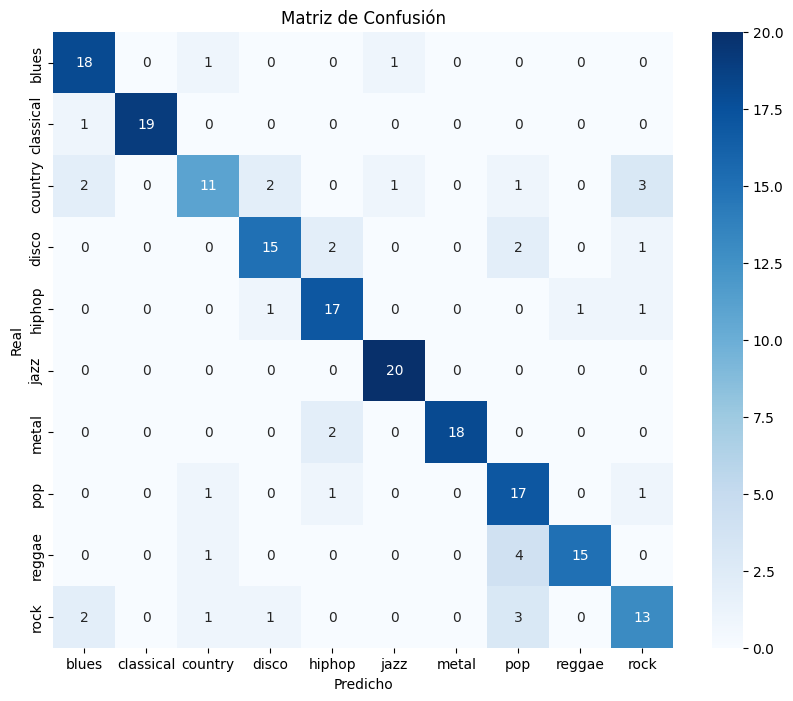

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Matriz de confusi√≥n
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.title("Matriz de Confusi√≥n")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


- G√©neros con mejor desempe√±o: jazz, classical, metal
- G√©neros m√°s confusos: pop, country, rock


## Gr√°ficos de m√©tricas: p√©rdida y precisi√≥n

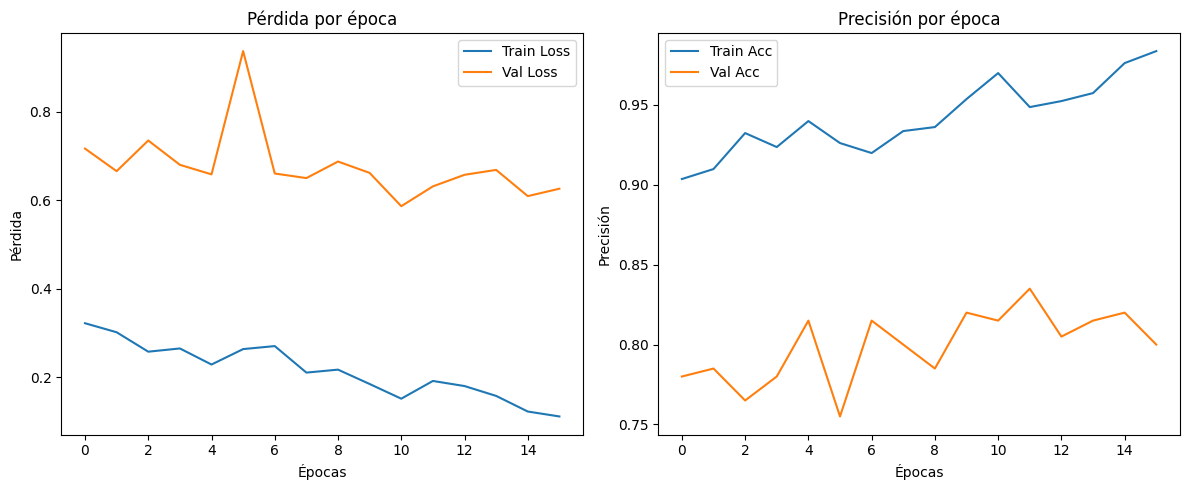

In [69]:
# Gr√°fica de la p√©rdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("√âpocas")
plt.ylabel("P√©rdida")
plt.title("P√©rdida por √©poca")
plt.legend()

# Gr√°fica de la precisi√≥n (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("√âpocas")
plt.ylabel("Precisi√≥n")
plt.title("Precisi√≥n por √©poca")
plt.legend()

plt.tight_layout()
plt.show()

## Funci√≥n para predecir g√©nero musical


In [70]:
def predecir_genero(audio_path):
    """
    Carga un archivo de audio, lo convierte a espectrograma Mel,
    lo pasa por el modelo entrenado y devuelve el g√©nero predicho.
    """

    # Convertimos el nuevo audio al mismo formato de entrada
    datos = audio_a_melspectrogram(audio_path)

    if datos is None:
        return ["Error al cargar el audio"]

    # Expandimos dimensi√≥n para que tenga forma (1, alto, ancho, canales)
    datos = np.expand_dims(datos, axis=0)

    # Realizamos la predicci√≥n
    pred = model.predict(datos)

    # Tomamos la clase con mayor probabilidad
    return encoder.inverse_transform([np.argmax(pred)])


    # Probamos con un audio real de prueba
ruta_test = os.path.join(DATASET_PATH, 'rock', 'rock.00001.wav')
print("Predicci√≥n:", predecir_genero(ruta_test)[0])

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step
Predicci√≥n: rock


# Modelo MobileNetV2

¬øQu√© es MobileNetV2?

MobileNetV2 es una red neuronal convolucional profunda dise√±ada para ser liviana y eficiente,
ideal para aplicaciones en dispositivos m√≥viles o con recursos limitados. Fue desarrollada por
Google y preentrenada sobre el dataset ImageNet. Usa bloques lineales invertidos y conexiones
residuales para lograr un buen balance entre precisi√≥n y velocidad. En este proyecto, se reutiliza
como extractor de caracter√≠sticas visuales sobre espectrogramas Mel transformados en im√°genes.

## Adaptar espectrogramas para MobileNetV2

In [46]:
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preparar_para_mobilenet(X):
    """
    Convierte espectrogramas monocrom√°ticos (1 canal) a RGB,
    los redimensiona a 224x224 y aplica el preprocesamiento espec√≠fico de MobileNetV2.
    """
    X_rgb = np.repeat(X, 3, axis=-1)  # Convertimos (alto, ancho, 1) ‚Üí (alto, ancho, 3)
    X_resized = np.zeros((X.shape[0], 224, 224, 3), dtype=np.float32)

    for i in range(X.shape[0]):
        X_resized[i] = cv2.resize(X_rgb[i], (224, 224))  # Resize a (224, 224)

    return preprocess_input(X_resized)  # Normaliza como espera MobileNetV2

In [47]:
# Preparamos datos para el nuevo modelo
X_train_mobilenet = preparar_para_mobilenet(X_train)
X_test_mobilenet = preparar_para_mobilenet(X_test)

## Crear modelo con MobileNetV2 como base

In [60]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.05),
])

input_shape = (224, 224, 3)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(len(GENRES), activation='softmax')(x)

model_optim = Model(inputs, outputs)

model_optim.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_optim = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
]

## Compilar y entrenar



In [61]:
history_optim = model_optim.fit(
    X_train_mobilenet, y_train,
    validation_data=(X_test_mobilenet, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_optim
)


Epoch 1/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 230ms/step - accuracy: 0.1265 - loss: 3.1342 - val_accuracy: 0.1850 - val_loss: 2.6443 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 78ms/step - accuracy: 0.1395 - loss: 2.8928 - val_accuracy: 0.2550 - val_loss: 2.5260 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 79ms/step - accuracy: 0.1761 - loss: 2.7138 - val_accuracy: 0.2950 - val_loss: 2.4502 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 79ms/step - accuracy: 0.2135 - loss: 2.6238 - val_accuracy: 0.3000 - val_loss: 2.3869 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 80ms/step - accuracy: 0.2288 - loss: 2.5597 - val_accuracy: 0.3050 - val_loss: 2.3384 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ‚îÅ‚îÅ

## Evaluaci√≥n final

## Gr√°ficos del entrenamiento de MobileNetV2


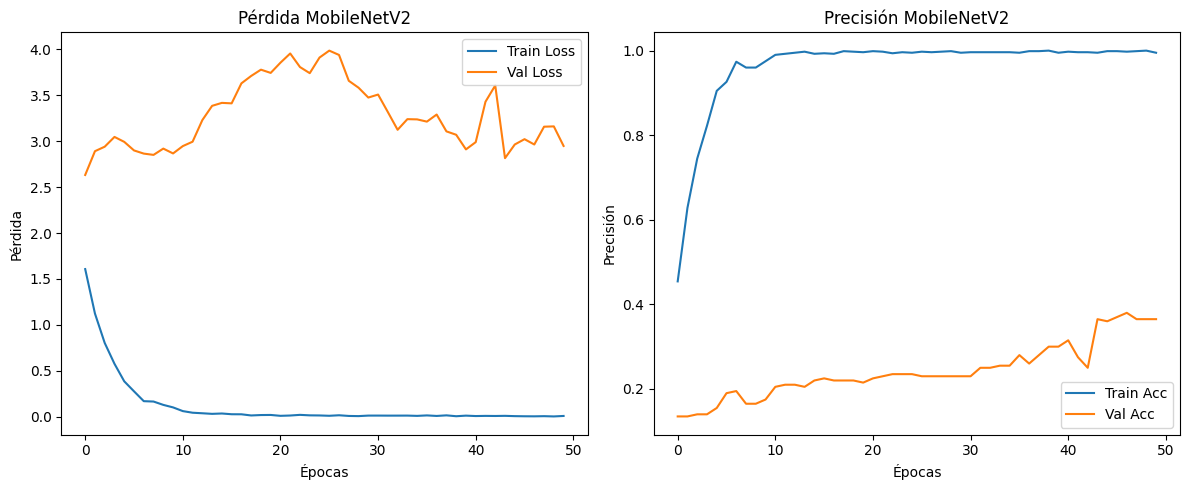

In [62]:
plt.figure(figsize=(12, 5))

#  P√©rdida
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.xlabel("√âpocas")
plt.ylabel("P√©rdida")
plt.title("P√©rdida MobileNetV2")
plt.legend()

#  Precisi√≥n
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Acc')
plt.xlabel("√âpocas")
plt.ylabel("Precisi√≥n")
plt.title("Precisi√≥n MobileNetV2")
plt.legend()

plt.tight_layout()
plt.show()

## Comparaci√≥n de Modelos CNN Y MobilenetV2

Mientras que el modelo con CNN personalizada logr√≥ un entrenamiento estable y alcanz√≥ buena precisi√≥n en validaci√≥n (‚âà81‚ÄØ%), la arquitectura MobileNetV2 no logr√≥ generalizar tan bien, mostrando p√©rdida alta y precisi√≥n limitada. Esta comparaci√≥n resalta que, en este caso, una red dise√±ada desde cero y adaptada al dominio super√≥ al modelo preentrenado.


# App Gradio con visualizaci√≥n de espectrograma

In [63]:
import gradio as gr
import matplotlib.pyplot as plt
import librosa.display
import io
import PIL.Image

# Funci√≥n para predecir g√©nero y mostrar espectrograma
def clasificar_con_visual(audio_path):
    # Obtener espectrograma
    spec = audio_a_melspectrogram(audio_path)

    if spec is None:
        return "Error procesando audio", None

    # Predecir g√©nero
    datos = np.expand_dims(spec, axis=0)
    pred = model.predict(datos)
    genero = encoder.inverse_transform([np.argmax(pred)])[0]

    # Visualizar espectrograma como imagen
    fig, ax = plt.subplots(figsize=(6, 3))
    librosa.display.specshow(spec.squeeze(), sr=22050, x_axis='time', y_axis='mel', cmap='magma', ax=ax)
    ax.set_title(f"Espectrograma - Predicci√≥n: {genero}")
    ax.axis('off')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = PIL.Image.open(buf)
    plt.close(fig)

    return genero, img

## interfaz


In [64]:
gr.Interface(
    fn=clasificar_con_visual,
    inputs=gr.Audio(type='filepath', label="üéµ Sub√≠ tu audio (.wav, 30s)"),
    outputs=[
        gr.Label(label="üéØ Predicci√≥n de g√©nero"),
        gr.Image(label="üìä Espectrograma generado")
    ],
    title="Clasificador de G√©neros Musicales",
    description="Sub√≠ tu archivo de audio en formato .wav (30 segundos) y mir√° qu√© g√©nero predice el modelo, junto con su espectrograma visual.",
    theme="default"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22822040ac70c7147d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Conclusi√≥n
En este proyecto implementamos y evaluamos un sistema de clasificaci√≥n autom√°tica de g√©neros musicales basado en espectrogramas Mel extra√≠dos de archivos de audio del dataset GTZAN. Para ello, dise√±amos una red neuronal convolucional personalizada y exploramos una arquitectura preentrenada MobileNetV2 con fine-tuning adaptado a nuestro dominio.

La representaci√≥n mediante espectrogramas Mel demostr√≥ ser una transformaci√≥n efectiva para captar caracter√≠sticas ac√∫sticas relevantes de cada g√©nero, facilitando el aprendizaje por parte de los modelos CNN. El an√°lisis exploratorio con PCA evidenci√≥ cierta agrupaci√≥n y diferenciaci√≥n entre g√©neros, aunque tambi√©n mostr√≥ solapamientos que explican dificultades en la clasificaci√≥n para algunos casos.

El modelo CNN personalizado, construido desde cero, alcanz√≥ una precisi√≥n mayor en comparaci√≥n con MobileNetV2, logrando un mejor ajuste a las caracter√≠sticas espec√≠ficas del dataset. En cambio, MobileNetV2, a pesar de ser una arquitectura profunda y eficiente dise√±ada para tareas generales y dispositivos m√≥viles, present√≥ un rendimiento inferior en este contexto. Esto podr√≠a deberse a que la transferencia de aprendizaje desde im√°genes naturales (ImageNet) no se adapt√≥ de manera √≥ptima a la naturaleza espectrogr√°fica y ac√∫stica de los datos, o a limitaciones en la cantidad de datos para un fine-tuning efectivo.

Ambos modelos incorporaron t√©cnicas de regularizaci√≥n y data augmentation para mejorar la generalizaci√≥n, pero el modelo CNN personalizado mostr√≥ mejor capacidad para discriminar los patrones ac√∫sticos propios de los g√©neros musicales del dataset.

Finalmente, aunque existen g√©neros con alta tasa de acierto (como jazz y classical), la confusi√≥n entre g√©neros similares (pop, rock, country) resalta la complejidad del problema y la necesidad de explorar mejoras adicionales, tales como extracci√≥n de caracter√≠sticas complementarias, arquitecturas h√≠bridas o modelos secuenciales que consideren din√°mica temporal.

Este trabajo demuestra el potencial de las redes convolucionales y las t√©cnicas de aprendizaje profundo para tareas de clasificaci√≥n musical, y abre la puerta a futuras investigaciones orientadas a aumentar la robustez y precisi√≥n en escenarios reales.

---

### Recursos y Referencias

- [GTZAN Dataset (Kaggle)](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)  
  Dataset de g√©neros musicales utilizado en el proyecto.

- [Librosa](https://librosa.org/doc/latest/index.html)  
  Librer√≠a de Python para an√°lisis y procesamiento de audio.

- [Keras - API de Deep Learning](https://keras.io/)  
  Documentaci√≥n oficial de Keras para construir y entrenar redes neuronales.

- [Gu√≠a de espectrogramas Mel (Librosa)](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html)  
  Explicaci√≥n t√©cnica y par√°metros clave para construir espectrogramas Mel.

- [MobileNetV2 en TensorFlow Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)  
  Detalles t√©cnicos sobre la arquitectura MobileNetV2.


- [Scikit-learn](https://scikit-learn.org/stable/)  
  Herramientas para preprocesamiento, reducci√≥n de dimensionalidad y m√©tricas de evaluaci√≥n.

- [Gradio](https://www.gradio.app/)  
  Framework para crear interfaces interactivas de Machine Learning f√°cilmente.

---
